NomicEmbeddings

Rag with metadata

Human in the loop

--------------------

patients identity hidden from llm

using python Relp for relative month in profile or policy comply

add database to google api

utilities:   
- patients DB creator

steps:
- Create Agents
- Define tools
- Create graph
- Define Agent Nodes
- Define Tool Node
- Define Edge Logic
- Define the Graph
- show the graph
- Invoke
  
- Human in the loop
- Maximum number of steps
- Helper Utilities

# LLM Agents for Clinical Trial Management

In this notebook, we develop an agent-based system to automate the management and analysis of clinical trial data, ensuring compliance with regulatory standards, and providing comprehensive reports for stakeholders. This pipeline also incorporate human-in-the-loop (HITL) and memory mechanisms to enhance functionality and accuracy.

## Steps and Plan

1. Define the Problem:

Objective: Automate clinical trial data management, analysis, compliance checks, and reporting.

Key Components: Data collection, data analysis, compliance verification, reporting, and human-in-the-loop interventions.

2. Design the Architecture:
**Agents:**
Data Collection Agent: Gathers patient data, trial results, and other relevant information.

Data Analysis Agent: Analyzes the collected data to generate reports on trial outcomes.

Compliance Agent: Ensures all data and processes adhere to regulatory standards.

Reporting Agent: Compiles and presents the analysis findings in comprehensive reports.

Human-in-the-Loop: Integrate a review phase where human experts validate data analysis and compliance checks before final reporting.

Memory: Utilize LangGraph’s memory capabilities to track the progress and history of each trial.

The Clinical Trial Matching Agent is designed to match patients wit	h suitable clinical trials based on their medical history, symptoms, and ongoing treatments. This application helps patients find relevant clinical trials they may be eligible for, improving their chances of accessing new treatments and contributing to medical research.


1. Database Setup
- SQLite Database: Create two databases:
- Patients DB: Stores patient medical history, previous trials, and other relevant data.
- Clinical Trials DB: Contains information about ongoing and upcoming clinical trials, including eligibility criteria.
2. Agents and Tools
- Patient Data Ingestion Agent: Retrieves patient data from the SQLite database or prompts the user to provide missing data.
- Data Validation and Collection Loop: Ensures all required fields are collected using persistence.
- Policy Compliance Agent: Cross-checks patient data with institutional policies.
- Trial Vectorization Agent: Extracts and vectorizes recruiting trials for efficient search.
- Trial Matching Agent: Forms prompts from patient data to search the vector database for potential trial matches.
- Human-in-the-Loop (HIL) Agent: Presents top trial matches to the user for selection.
- Persistence Mechanism: Allows the application to save and resume states, especially useful for collecting patient data and searching trials.

In [1]:
%load_ext autoreload
%autoreload 2
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Clinical Trial Management"

In [2]:
from langchain_openai import ChatOpenAI


vstore_created = False
trials_vstore_created = False
trials_db_downloaded = False
modelID = "gpt-3.5-turbo"
n_retrieved_policies = 6
# n_retries = 6
n_retrieved_trials = 6

model = ChatOpenAI(temperature = 0.0, model=modelID)

In [3]:
# import os

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file

import warnings
warnings.filterwarnings("ignore")

import pprint
# A function for printing nicely
def nprint(text, indent=2):
    pp = pprint.PrettyPrinter(indent=indent)
    pp.pprint(text)

# Creating the sample datasets

## Patients database

In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Generate the sample data again for display
columns = ["patient_id", "name", "age", "medical_history", "previous_trials", "trial_status", "trial_completion_date"]
data = []

import random

# Given names and surnames
names = ["John", "Jane", "Alice", "Michael", "Emily", "Daniel", "Sophia", "James", "Emma", "Oliver"]
surnames = ["Doe", "Smith", "Johnson", "Brown", "Davis", "Garcia", "Martinez", "Anderson", "Thomas", "Wilson"]

# Generate all possible unique combinations of names and surnames
combinations = [(name, surname) for name in names for surname in surnames]

# Shuffle the combinations to ensure randomness
random.shuffle(combinations)

# Select the first 100 unique combinations
unique_names = combinations[:100]

# Generate the full names
full_names = [f"{name} {surname}" for name, surname in unique_names]

# Display the first few full names for verification
print(full_names[:10])

# Optionally, you can also display all 100 unique full names
# print(len(full_names))
# unique entries of list full_names
print(len(set(full_names)))


import numpy as np
import json

with open('../../source_data/diseases_list.json', 'r') as file:
        trial_diseases =  json.load(file)

list_trial_diseases = list({disease for diseases in trial_diseases.values() for disease in diseases})

other_medical_conditions = ["Hypertension", "Diabetes", "Asthma", "Heart Disease", "Arthritis",
                      "Chronic Pain", "Anxiety", "Depression", "Obesity"]

all_conditions = list(set(list_trial_diseases + other_medical_conditions))

trial_statuses = ["Completed", "Ongoing", "Withdrawn"]

def random_date(start, end):
    return start + timedelta(days=random.randint(0, int((end - start).days)))

# start_date must be 2 years before now
start_date = datetime.now() - timedelta(days=365 * 2)
# start_date = datetime(2020, 1, 1)

# end_date must be a month before now
end_date = datetime.now() - timedelta(days=10)
# end_date = datetime(2023, 1, 1)

for i in range(1, 101):
    name = random.choice(full_names)
    age = random.randint(20, 80)
    medical_history = random.choice(all_conditions)
    
    if random.choice([True, False]):
        previous_trials = f"Trial {random.randint(1, 20)}"
        trial_status = random.choice(trial_statuses)
        trial_completion_date = random_date(start_date, end_date).strftime('%Y-%m-%d')
    else:
        previous_trials = ""
        trial_status = ""
        trial_completion_date = ""
    if trial_status == "Ongoing":
        trial_completion_date = ""

    data.append((i, name, age, medical_history, previous_trials, trial_status, trial_completion_date))

df = pd.DataFrame(data, columns=columns)
# save df to csv
df.to_csv("patients.csv", index=False)
df.head(20)

['Sophia Martinez', 'James Brown', 'Alice Davis', 'James Thomas', 'Emily Wilson', 'Jane Wilson', 'Emily Davis', 'Oliver Doe', 'Oliver Garcia', 'Daniel Brown']
100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,John Johnson,40,myelomonocytic leukemia,,,
1,2,Emma Martinez,39,depressive disorder,Trial 18,Completed,2024-04-29
2,3,Oliver Martinez,30,Obesity,Trial 18,Withdrawn,2023-11-18
3,4,Michael Doe,55,leiomyosarcoma,,,
4,5,Emma Wilson,24,colorectal cancer,Trial 3,Withdrawn,2023-02-11
5,6,Jane Martinez,43,Arthritis,Trial 6,Withdrawn,2022-11-01
6,7,Oliver Davis,33,soft tissue sarcoma,Trial 8,Withdrawn,2022-06-29
7,8,Daniel Johnson,51,colorectal cancer,,,
8,9,Sophia Doe,54,Chronic Pain,Trial 5,Ongoing,
9,10,James Brown,30,esophageal cancer,Trial 17,Ongoing,


In [5]:
# df[df['trial_completion_date'] >= '2024-01-01']
df[df['medical_history'].str.contains('leukemia')]
# df[df['diseases'].has ]

,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,John Johnson,40,myelomonocytic leukemia,,,
12,13,Sophia Martinez,33,lymphoblastic leukemia,,,
23,24,Sophia Thomas,51,lymphoblastic leukemia,,,
40,41,Michael Thomas,63,lymphoblastic leukemia,Trial 11,Completed,2024-05-06
58,59,Daniel Brown,37,myeloid leukemia,,,
71,72,Sophia Davis,76,lymphoblastic leukemia,,,
74,75,Daniel Garcia,79,myelomonocytic leukemia,,,
75,76,Emma Martinez,63,lymphoblastic leukemia,,,
82,83,Emma Doe,52,myeloid leukemia,,,
98,99,Emily Davis,32,lymphoblastic leukemia,,,


In [6]:
import os
# import shutil
import sqlite3

import pandas as pd

overwrite = True

database_file = 'patients_database.db'
df = pd.read_csv('patients.csv')
if overwrite or not os.path.exists(database_file):
    if os.path.exists(database_file):
        os.remove(database_file)
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS patients (
        patient_id INTEGER PRIMARY KEY,
        name TEXT,
        age INTEGER,
        medical_history TEXT,
        previous_trials TEXT,
        trial_status TEXT,
        trial_completion_date TEXT
    )
    ''')

    # Insert DataFrame into SQLite table
    df.to_sql('patients', conn, if_exists='append', index=False)

    # Commit and close the connection
    conn.commit()
else:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

query = 'SELECT * FROM patients'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)
print(len(df))

# Display the DataFrame
conn.close()

db = database_file
df.head(10)

100


,patient_id,name,age,medical_history,previous_trials,trial_status,trial_completion_date
0,1,John Johnson,40,myelomonocytic leukemia,None,None,None
1,2,Emma Martinez,39,depressive disorder,Trial 18,Completed,2024-04-29
2,3,Oliver Martinez,30,Obesity,Trial 18,Withdrawn,2023-11-18
3,4,Michael Doe,55,leiomyosarcoma,None,None,None
4,5,Emma Wilson,24,colorectal cancer,Trial 3,Withdrawn,2023-02-11
5,6,Jane Martinez,43,Arthritis,Trial 6,Withdrawn,2022-11-01
6,7,Oliver Davis,33,soft tissue sarcoma,Trial 8,Withdrawn,2022-06-29
7,8,Daniel Johnson,51,colorectal cancer,None,None,None
8,9,Sophia Doe,54,Chronic Pain,Trial 5,Ongoing,None
9,10,James Brown,30,esophageal cancer,Trial 17,Ongoing,None


## Clinical Trials database

In [7]:
import sys
module_dir = os.path.abspath('../../src')  # Gets the absolute path to the src directory
sys.path.append(module_dir)
from helper_functions import dataset_create_trials

overwrite = True
if trials_db_downloaded and not overwrite:
    print(f'Trials database already downloaded and stored in {trials_path}')
    df_trials = pd.read_csv(trials_path)
else:
    df_trials, trials_path = dataset_create_trials(status='recruiting')
    trials_db_downloaded = True

# print the ctriteria column value froom 4 random rows of the dataferam. use a for loop
df_samples = df_trials.sample(4).reset_index(drop=True)
for i in range(4):
    print(f'---- Sample {i+1} ----')
    print(df_samples.iloc[i]['criteria'])


Only trials with status recruiting are selected.
The database for trials is saved to ../../data/trials_data.csv 
 It has 30 rows.
---- Sample 1 ----

        Inclusion Criteria:

          1. Subject is at least 20 years of age.

          2. Subject has a histologically or cytologically confirmed diagnosis of urothelial
             carcinoma arising from urinary bladder or upper urinary tract.

          3. Subject has been treated with platinum-based chemotherapy for advanced disease. They
             must have refractory or progressive disease for which there is no further curative
             therapy available.

          4. Subject has been treated with platinum-based chemotherapy for advanced disease. They
             must have refractory or progressive disease for which there is no further curative
             therapy available.

             Subject has a tumor that carries a missense HRAS mutation according to a standard
             methodology using Illumina HiSeqTM. (m

## Tools

In [8]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

def get_patient_data(patient_id: int) -> dict:
    """Fetch all fields for the patient based on the given patient_id as an integer.

    Returns:
        A dictionary containing the patient's medical history.        
    """

    # config = ensure_config()  # Fetch from the context
    # configuration = config.get("configurable", {})
    # patient_id = configuration.get("patient_id", None)

    # if not patient_id:
    #     raise ValueError("No patient ID given.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()    
    query = 'SELECT * FROM patients WHERE patient_id=?'
    cursor.execute(query, (patient_id,))
    patient_data = cursor.fetchone()
    # rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    conn.close()
    if patient_data is None:
        return None
    else:    
        results = dict(zip(column_names, patient_data))    
    return results


def add_patient_data(patient_data: dict):    
    """Adds a new patient to the SQLite database."""
    
    name = patient_data['name']
    age = patient_data['age']
    medical_history = patient_data['medical_history']
    previous_trials = patient_data['previous_trials']
    trial_status = patient_data['trial_status']
    last_trial_dates = patient_data['last_trial_dates']

    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    
    # Insert the new patient data into the database
    cursor.execute('''
    INSERT INTO patients (name, age, medical_history, previous_trials, trial_status, last_trial_dates)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, medical_history, previous_trials, trial_status, last_trial_dates))
    
    conn.commit()
    conn.close()


In [9]:
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
print(patient_data)
patient_data

{'patient_id': 4, 'name': 'Michael Doe', 'age': 55, 'medical_history': 'leiomyosarcoma', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}


{'patient_id': 4,
 'name': 'Michael Doe',
 'age': 55,
 'medical_history': 'leiomyosarcoma',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

### vectorstore for policy database

local embedding via NomicEmbeddings

In [59]:
# from gpt4all import Embed4All
# model_name = 'nomic-embed-text-v1.5.f16.gguf'
# text = 'The quick brown fox jumps over the lazy dog'
# # you can change it to cuda if you have available GPU
# embedder = Embed4All(model_name, device='cpu')
# output = embedder.embed(text)
# print(len(output))

import re

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document


markdown_path = "../../source_data/instut_trials_policy.md"

with open(markdown_path, "r") as f:
    policy_text = f.read()


doc_splits = [
    Document(page_content= txt, metadata={"source": markdown_path}) for txt in re.split(r"(?=\n###)", policy_text)
    ]

# the title of markdown is not required in the split
doc_splits = doc_splits[1:]    

# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    # chunk_size=250, chunk_overlap=0
# )
# doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))
doc_splits

# Add to vectorDB
# load the existing vectorstore from "rag-chroma"


if vstore_created:
    vectorstore.delete_collection()

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local'),
)
vstore_created = True
doc_splits


12


[Document(page_content='\n#### 1. **General Eligibility Criteria**\n   - **Age Restrictions**: Patients must be between 18 and 75 years old.\n   - **Gender**: No restrictions unless specified by the trial protocol.\n   - **Informed Consent**: All patients must provide informed consent prior to participation.\n   - **Residency**: Patients must be residents of the country where the trial is conducted.\n   - **Health Insurance**: Patients must have valid health insurance coverage.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 2. **Medical History Restrictions**\n   - **Severe Heart Disease** (e.g., recent myocardial infarction, heart failure)\n   - **Uncontrolled Diabetes Mellitus**     \n   - **Recent Surgeries**: Patients who have undergone major surgery within the current year are not eligible.   \n   - **Infectious Diseases**: Patients with active tuberculosis, hepatitis B or C, or HIV are excluded unless the trial is specificall

In [60]:
retriever = vectorstore.as_retriever(search_kwargs={"k": n_retrieved_policies})
# question = "policy about patient's past trials"
question = "\ntrial_completion_date: 2024-04-01"
docs_retrieved = retriever.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content
print(doc_txt)
docs_retrieved

6

#### 3. **Previous Trial Participation**   
   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.
   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.
   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the current year to allow for proper assessment of any delayed adverse effects.
   - **Trial Outcomes**:
     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.
     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.



[Document(page_content='\n#### 3. **Previous Trial Participation**   \n   - **Trial Frequency**: Patients should not have participated in more than two clinical trials in the past year excluding this trial to prevent overexposure to experimental treatments.\n   - **Active Trials**: Patients currently enrolled in another active trial are not eligible until they have completed or withdrawn from the ongoing trial.\n   - **Recent Trials**: Patients cannot have participated in any other clinical trial within the current year to allow for proper assessment of any delayed adverse effects.\n   - **Trial Outcomes**:\n     - Patients who were withdrawn from previous trials due to adverse effects are not eligible.\n     - Patients who have completed a trial must have a documented recovery period before participating in a new trial.\n', metadata={'source': '../../source_data/instut_trials_policy.md'}),
 Document(page_content='\n#### 4. **Medication and Treatment Restrictions**\n   - **Concurrent M

In [12]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 4
patient_data = get_patient_data(sample_patient_id)
# print(patient_data)
# patient_data
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

{'patient_id': 4,
 'name': 'Michael Doe',
 'age': 55,
 'medical_history': 'leiomyosarcoma',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

### Vstore for trials

we just work on 3 main categories of cancer, lukemia, and mental health problems as a demo application.

For a more proper application, this must be done with the help of domain specialists.

In [13]:
# from langchain.document_loaders import CSVLoader
# file = '../../data/trials_data.csv'
# df_trials = pd.read_csv(file)
from helper_functions import disease_map

trial_docs = []
for i, row in df_trials.iterrows():
    disease = disease_map(row['diseases'])
    if disease == 'other_conditions':
        continue
    doc = Document(
        page_content=row['criteria'],
        metadata={
            "nctid": row['nctid'],
            "status": row['status'],
            # "why_stop": row['why_stop'],
            # "label": row['label'],
            # "phase": row['phase'],
            "diseases": str(row['diseases']),
            "disease_category": disease[0],
            "drugs": row['drugs'],            
        }
    )
    trial_docs.append(doc)
# trial_docs

print(trial_docs[0].metadata)

list_remove = set()
for i, doc in enumerate(trial_docs):
    if len(doc.page_content)>10000:
        list_remove.add(i)
        # print(doc.metadata)
    if doc.metadata['disease_category'] == 'other_conditions':
        list_remove.add(i)
        # print(doc.metadata)
# remove list_remove indexes from trial_docs
trial_docs = [doc for i, doc in enumerate(trial_docs) if i not in list_remove]


{'nctid': 'NCT00715611', 'status': 'recruiting', 'diseases': "['mesothelioma']", 'disease_category': 'cancer', 'drugs': "['pemetrexed and cisplatin or carboplatin']"}


In [14]:
# print(len(trial_docs[11].page_content))
# trial_docs.pop(11)

if trials_vstore_created:
    vectorstore_trials.delete_collection()

vectorstore_trials = Chroma.from_documents(
    documents=trial_docs,
    collection_name="trials-chroma",
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local'),
)
trials_vstore_created = True

### Retriever Trials

In [15]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="disease_category",
        description="Defines the disease group of patients related to this trial. One of ['cancer', 'leukemia', 'mental_health']",
        # description="The trial is for patients when their disease is related to this category. One of ['cancer', 'leukemia', 'mental_health']",
        type="string",
    ),
    AttributeInfo(
        name="drugs",
        description="List of drug names used in the trial",
        type="str",
    ),    
]

document_content_description = "The list of patient conditions to include or exclude them from the trial"
retriever_trial_sq = SelfQueryRetriever.from_llm(
    model,
    vectorstore_trials,
    # vectorstore_trials_mpnet,
    document_content_description,
    metadata_field_info
    # enable_limit=True
)

In [16]:
retriever_trials = vectorstore_trials.as_retriever(search_kwargs={"k": n_retrieved_trials})
# question = trial_docs[trail_smp].page_content
question = """
Which trials are relevant to patient who has adenocarcinoma illness?
"""

# question = f"""
# Which trials are relevant to the patient with the following medical history?\n
# patient_profile: {patient_profile}
# """
# nprint(question)

# Which four trials are for patients with mental problem?
# print(trial_docs[trail_smp].metadata['nctid'])
# question = "Inclusion Criteria:\r\n\r\n          1. Subject"
docs_retrieved = retriever_trials.get_relevant_documents(question)
# docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

6
cancer ['prostate cancer']
cancer ['metastatic pancreatic cancer']
cancer ['rectal cancer']
cancer ['colorectal cancer']
cancer ['pancreatic ductal adenocarcinoma']
cancer ['stage iv non-small cell lung cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          -  Histologically confirmed metastatic or advanced prostate adenocarcinoma that has been\r\n             previously treated with docetaxel-based therapy and has progressed during treatment of\r\n             at least one hormonal therapy(prior docetaxel is not required for the safety cohort)\r\n\r\n          -  Two rising PSA levels greater than or equal to (>/=) 2 ng/mL measured >/= 1 week apart\r\n             or radiographic evidence of disease progression in soft tissue or bone\r\n\r\n          -  Eastern Cooperative Oncology Group (ECOG) performance status of 0 or 1 at screening\r\n\r\n          -  Adequate hematologic and organ function\r\n\r\n          -  Documented willingness to use an effective means of contraception\r\n\r\n          -  Safety cohort only: agreement to use CGM for first cycle of treatment\r\n\r\n        Exclusion Criteria:\r\n\r\n          -  History of Type I or Type II diabetes mellitus 

dummy : profile creator llm

In [20]:
def patient_data_to_string(patient_data):
    return " \n ".join([f"{key}: {value}" for key, value in patient_data.items()])

patient_id = 7
patient_data = get_patient_data(patient_id)
patient_data
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}

# patient_medical_history = patient_data_to_string(patient_data)


{'patient_id': 7,
 'name': 'Oliver Davis',
 'age': 33,
 'medical_history': 'soft tissue sarcoma',
 'previous_trials': 'Trial 8',
 'trial_status': 'Withdrawn',
 'trial_completion_date': '2022-06-29'}

### Profile Creator

In [21]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
parser = StrOutputParser()

# def patient_data_to_string(patient_data):
    # return " \n".join([f"{key}: {value}" for key, value in patient_data.items()])

prompt_profile = PromptTemplate(
    template="""
    You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
    Use the following patient data to write the patient profile for the screening phase.
    The patient profile is a summary of patient information.
    The patient profile also suggests relevant medical trials based on patient's medical history.
    Write the patient profile in 3 to 4 short sentences.\n\n
    {patient_data}""",
    input_variables=["patient_data"],
)
# model = ChatOpenAI(temperature = 0.0, model=modelID)

chain_profile = prompt_profile | model | parser
# keys_to_include = ['age', 'medical_history']
# patient_data = {key: patient_data[key] for key in keys_to_include}
if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient is a 33-year-old with a history of soft tissue sarcoma. They were '
 'previously enrolled in Trial 8 but withdrew before completion on June 29, '
 '2022. Based on their medical history, they may be eligible for upcoming '
 'clinical trials targeting soft tissue sarcoma.')


In [19]:
question = f"""
Which trials are relevant to the patient with the following medical history?\n
patient_profile: {patient_profile}
"""
# patient_profile: {patient_profile}
# question = """
# Which trials are relevant to the patient with the medical history of myeloid leukemia?
# """
nprint(question)

# docs_retrieved = retriever_trials.get_relevant_documents(question)
docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
print(len(docs_retrieved))
doc_txt = docs_retrieved[0].page_content[:]
nctid = docs_retrieved[0].metadata['nctid']
for doc in docs_retrieved:
    diseases = doc.metadata['diseases']
    disease_category = doc.metadata['disease_category']
    print(disease_category, diseases)
docs_retrieved

('\n'
 'Which trials are relevant to the patient with the following medical '
 'history?\n'
 '\n'
 'patient_profile: Patient Profile:\n'
 'The patient is a 51-year-old with a history of colorectal cancer. They have '
 'not participated in any previous trials and their current trial status is '
 'unknown. No trial completion date has been recorded.\n'
 '\n'
 'Relevant Medical Trials:\n'
 '1. Colorectal Cancer Treatment Trial - This trial focuses on new treatment '
 'options for colorectal cancer patients, which may be beneficial for this '
 'patient based on their medical history.\n'
 '2. Cancer Survivorship Study - This trial aims to improve the quality of '
 'life for cancer survivors, which could be relevant for this patient '
 'post-treatment.\n')
4
cancer ['colorectal cancer']
cancer ['rectal cancer']
cancer ['ovarian cancer', 'fallopian tube', 'primary peritoneal cancer', 'recurrent ovarian cancer']
cancer ['metastatic pancreatic cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          1. Subject is at least 20 years of age.\r\n\r\n          2. Written and voluntary informed consent understood, signed and dated.\r\n\r\n          3. They must have refractory or progressive colorectal cancer for which there is no\r\n             further curative therapy available.\r\n\r\n          4. Subject able to adhere to the study visit schedule and other protocol requirements.\r\n\r\n          5. ECOG 0-2\r\n\r\n          6. At least one measurable lesion that can be accurately assessed by imaging or physical\r\n             examination at baseline and following up visits.\r\n\r\n          7. Must have a life expectancy of 3 months or more\r\n\r\n          8. Demonstrate adequate organ function\r\n\r\n          9. Negative urine or serum pregnancy test within 28 days of study treatment\r\n\r\n         10. Be willing to provide fresh tissue for biomarker analysis, and, based on the adequacy\r\n             of t

### policy checker

In [46]:

import langchain
from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain.prompts import PromptTemplate
from operator import itemgetter

# patient_profile = patient_data_to_string(patient_data)

# print(patient_profile)

langchain.debug = False

question = f"""
Does the following patient profile comply with the institutional policies?\n
{patient_profile}
"""

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

from langchain.chains import RetrievalQA


class comply(BaseModel):
        """Binary score for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use NA")
        
# model = ChatOpenAI(temperature = 0.0, model=modelID)
llm_with_tool = model.with_structured_output(comply)
# qa = RetrievalQA.from_chain_type(
#     llm=llm_with_tool,
#     chain_type="stuff",
#     retriever=retriever,
# )

# completion_chroma = qa.run(question)
docs_retrieved = retriever.get_relevant_documents(question)
docs_retrieved


# completion = qa.run(question)
# completion
docs_retrieved = retriever.get_relevant_documents(question)
docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
docs

prompt_policy = PromptTemplate(
    template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
        Here are the retrieved policies: \n\n {context} \n\n
        Here is the user question: {question} \n
        Use the current date {date}, as the reference date to evaluate time related policies.\n        
        Giving a reason is required only for rejection cases.
        Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
    input_variables=["context", "question"],
)

# date = datetime.now().strftime("%Y-%m-%d")
date = datetime.today().strftime("%B %Y")

# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like


# llm_with_tool = model.with_structured_output(comply)

# chain = prompt | model
# chain = prompt | llm_with_tool
# chain = ( 
#     {"patient_profile" : chain_profile, "question" : itemgetter('question'),
#      "context" : itemgetter('context'), "date" : itemgetter('date')} | prompt | llm_with_tool
# )

chain = prompt_policy | llm_with_tool

if patient_data.get('name'):
    del patient_data['name']
    del patient_data['patient_id']

scored_result = chain.invoke(
    {
        "question": question, 
        "context": docs, 
        "date": date
        # "patient_data": patient_data
    }
)
scored_result

comply(binary_score='yes', reason='NA')

In [350]:
datetime.today().strftime("%B %Y")

'June 2024'

In [330]:
question

'\nDoes the following patient profile comply with the institutional policies?\n\nPatient is a 24-year-old with a history of anxiety disorder. They have not participated in any previous trials and their current trial status is complete. No trial completion date is provided. Based on their medical history, relevant medical trials may include those focused on anxiety disorders or mental health interventions.\n'

In [22]:
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_institution_policies",
    "Search and return information about the institution's policies about conducting clinical trials based on the patient's information.",
)

tools = [retriever_tool]

### Retrieval Grader

In [100]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
# cancer:22, asthma:4, leukemia: 8, anx disorder: 7
sample_patient_id = 8
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
del patient_data['name']
del patient_data['patient_id']
# patient_data['trial_status'] = 'Complete'
patient_data

{'age': 51,
 'medical_history': 'colorectal cancer',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

In [101]:
# date
patient_profile = chain_profile.invoke({'patient_data': patient_data})
nprint(patient_profile)

('Patient Profile:\n'
 'The patient is a 51-year-old with a history of colorectal cancer. They have '
 'not participated in any previous trials and their current trial status and '
 'completion date are unknown.\n'
 '\n'
 'Relevant Medical Trials:\n'
 '1. Colorectal Cancer Treatment Trial - This trial focuses on new treatment '
 'options for patients with colorectal cancer, which may be beneficial for '
 'this patient based on their medical history.\n'
 '2. Cancer Survivorship Study - This trial aims to improve the quality of '
 'life for cancer survivors, which could be relevant for this patient '
 'post-treatment.')


In [102]:
docs = retriever_trial_sq.get_relevant_documents(patient_profile)
for doc in docs:
    print(doc.metadata.get("disease_category"), doc.metadata.get("diseases"))
docs    

cancer ['colorectal cancer']
cancer ['rectal cancer']
cancer ['ovarian cancer', 'fallopian tube', 'primary peritoneal cancer', 'recurrent ovarian cancer']
cancer ['metastatic pancreatic cancer']


[Document(page_content='\n        Inclusion Criteria:\r\n\r\n          1. Subject is at least 20 years of age.\r\n\r\n          2. Written and voluntary informed consent understood, signed and dated.\r\n\r\n          3. They must have refractory or progressive colorectal cancer for which there is no\r\n             further curative therapy available.\r\n\r\n          4. Subject able to adhere to the study visit schedule and other protocol requirements.\r\n\r\n          5. ECOG 0-2\r\n\r\n          6. At least one measurable lesion that can be accurately assessed by imaging or physical\r\n             examination at baseline and following up visits.\r\n\r\n          7. Must have a life expectancy of 3 months or more\r\n\r\n          8. Demonstrate adequate organ function\r\n\r\n          9. Negative urine or serum pregnancy test within 28 days of study treatment\r\n\r\n         10. Be willing to provide fresh tissue for biomarker analysis, and, based on the adequacy\r\n             of t

In [118]:
from langchain_core.output_parsers import JsonOutputParser

class grade(BaseModel):
        """The result of the trial's relevance check as relevance score and explanation."""

        relevance_score: str
        # explanation: str = Field(description="Reason(s) if the patient meets any exclusion criteria.")
        explanation: str = Field(description="Reasons to the given relevance score.")
        # further_information: str = Field(description="If further information about the patient is requeied related to the trial's criteria.")
        further_information: str

        # relevance_score: str = Field(description="Relevance of the trial criteria to the patient's profile. Possible choices 'Yes', 'No', or 'Maybe'.")
        # relevance_score: str = Field(description="Yes', 'No', or 'Maybe'.")
        # explanation: str = Field(description="Reason(s) if the patient meets any exclusion criteria.")
        # explanation: str = Field(description="Reason(s) if the patient does not meet or meet the trial's criteria. Othereise use N/A")
        # further_information: str = Field(description="If further information is requeied to make the decision about the trial's relevance. Othereise use N/A")

        # class Config:
        #     schema_extra = {
        #         "example 1": {
        #             "relevance_score": 'No',
        #             "explanation": "Patient has a history of diabetes mellitus which is an exclusion criteria.",
        #             "further_information": "N/A",
        #         },
        #         "example 2": {
        #             "relevance_score": 'Yes',
        #             "explanation": "Patient had a prostate adenocarcinoma in the past which is an inclusion criteria.",
        #             "further_information": "N/A",
        #         },
        #         "example 3": {
        #             "relevance_score": 'Maybe',
        #             "explanation": "Patient has pancreatic cancer as an inclusion criteria.",
        #             "further_information": "Patient's BMI and the current stage of their pancreatic cancer is required for further evaluation.",
        #         },                
        #     }

prompt_grader = PromptTemplate(
        template=""" 
        You are a Principal Investigator (PI) for evaluating patients for clinical trials.\n
        Your task is to evaluate the relevance of a clinical trial to the given patient's medical profile. \n
        
        
        The clinical trial is related to these diseases: {trial_diseases} \n
        Here are the inclusion and exclusion criteria of the trial: \n\n {document} \n\n
        
        ===============                
        Use the following steps to determine relevance and provide the necessary fields in your response: \n
        1- If the patient's profile meets any exclusion criteria, then the trial is not relevant --> relevance_score = 'No'. \n
        2- If the patient's has or had the trial's inclusion diseases, then it is relevant --> relevance_score = 'Yes'.\n        
                       
        Example 1: 
The patient has Arthritis and the trial is related to pancreatic cancer. --> relevance_score = 'No' \n
        
        Example 2: 
The patient has pancreatic cancer and the trial is also related to carcinoma pancreatic cancer. --> relevance_score = 'Yes' \n

        Example 3: 
The patient has pancreatic cancer and the trial is related to breast cancer or ovarian cancer. --> relevance_score = 'No'. \n 

        Bring your justification in the explanation. \n

        Mention further information that is needed from the patient's medical history related to the trial's criteria \n

        ===============
        Here is the patient's medical profile: {patient_profile} \n\n
        """,
        input_variables=["document", "patient_profile", "trial_diseases"],
    )

llm_with_tool = model.with_structured_output(grade)

# retrieval_grader = prompt_grader | model
retrieval_grader = prompt_grader | llm_with_tool
# retrieval_grader = prompt_grader | model | JsonOutputParser()

# docs = retriever_trial_sq.get_relevant_documents(patient_profile)
doc = docs[0]
doc_txt = doc.page_content
trial_diseases = doc.metadata.get("diseases")
# patient_profile = "Patient has a history of esophageal cancer"
trial_score = retrieval_grader.invoke({"patient_profile": patient_profile, "document": doc_txt, "trial_diseases": trial_diseases})

for score in trial_score:
    nprint(score)
nprint(patient_profile)
print(trial_diseases)
print(doc_txt)

('relevance_score', 'Yes')
( 'explanation',
  'The patient has a history of colorectal cancer, which aligns with the '
  'disease targeted by the clinical trial. This makes the trial relevant to '
  "the patient's medical profile.")
( 'further_information',
  'Additional information needed from the patient includes confirmation of '
  'age, signing of informed consent, current status of colorectal cancer, '
  'adherence to study visit schedule, ECOG score, presence of measurable '
  'lesion, life expectancy, organ function, pregnancy test results, '
  'willingness to provide tissue for biomarker analysis, and any recent '
  'treatments or medications taken.')
('Patient Profile:\n'
 'The patient is a 51-year-old with a history of colorectal cancer. They have '
 'not participated in any previous trials and their current trial status and '
 'completion date are unknown.\n'
 '\n'
 'Relevant Medical Trials:\n'
 '1. Colorectal Cancer Treatment Trial - This trial focuses on new treatment '
 '

In [316]:
trial_score
trial_score_dic = dict(trial_score)
trial_score_dic
nctid = 'NCT00785735'
trial_score_dic['nctid'] = nctid
# relevant_trials.append(score)

In [202]:
for score in trial_score:
    nprint(score)
print(doc_txt)

('relevance_score', 'Maybe')
( 'explanation',
  "The patient's medical history of asthma may be relevant to the trial as "
  'asthma is a respiratory condition that could potentially be linked to '
  'generalized anxiety disorder. However, further information is needed to '
  'confirm the relevance, such as the severity of the asthma and its impact on '
  "the patient's overall health and participation in the trial.")
( 'further_information',
  "Patient's medical history of asthma may have implications on their "
  'eligibility for the trial, but additional details are required to make a '
  'definitive assessment.')

        Inclusion Criteria:

          -  Patients of both sexes

          -  Eighteen years of age and older

          -  Clinical diagnosis of Generalized Anxiety Disorder

          -  Eighteen points or more on Hamilton Anxiety Scale

          -  Without previous treatment for this disease (for at least one month before).

          -  In case of being women of rep

# State

In [25]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document

# from typing import TypedDict

class AgentState(TypedDict):
    patient_prompt: str
    patient_id: int    
    policy_eligible: bool
    rejection_reason: str
    patient_data: dict
    patient_profile: str
    revision_number: int
    max_revisions: int
    policies: List[Document]
    trials: list[Document]
    relevant_trials: list[dict]

## Agent

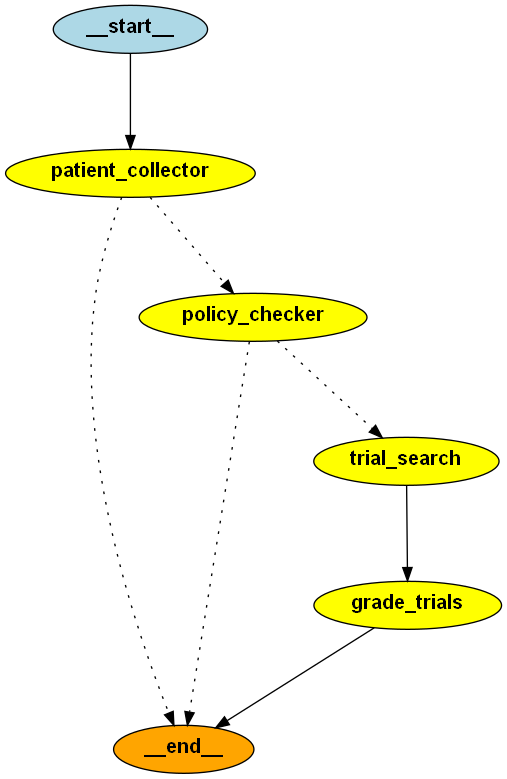

In [119]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.pydantic_v1 import BaseModel, Field
from operator import itemgetter
from typing import Literal


model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost

memory = SqliteSaver.from_conn_string(":memory:")



# ------- Agents:
class Patient_ID(BaseModel):
    patient_id: int
    # no_id: bool

# model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)  #reduce inference cost
patient_data_prompt = """You are a helpful assistance in extrcting patient's medical history.
Based on the following request identify and return the patient's ID number.
"""
# If you cannot find patient ID in the request text then return 10000 as response.

def patient_collector_node(state: AgentState):
    response = model.with_structured_output(Patient_ID).invoke([
        SystemMessage(content=patient_data_prompt),
        HumanMessage(content=state['patient_prompt'])
    ])
    patient_id = response.patient_id
    print(response)
    print(f"Patient ID: {patient_id}")
    result = get_patient_data(patient_id)
    
    return {
        "patient_data": result,
        "patient_id": patient_id,
        "revision_number": state.get("revision_number", 1) + 1
        }


def policy_checker(state: AgentState):
    # Convert patient_data to string
    
    parser = StrOutputParser()
    prompt_profile = PromptTemplate(
        template="""
        You are the Clinical Research Coordinator in the screening phase of a clinical trial. 
        Use the following patient data to write the patient profile for the screening phase.
        The patient profile is a summary of patient information.
        The patient profile also suggest relevant medical trials based on patient's medical history.
        Write the patient profile in 3 to 4 short sentences.\n\n
        {patient_data}""",
        input_variables=["patient_data"],
    )
    # model = ChatOpenAI(temperature = 0.0, model=modelID)

    chain_profile = prompt_profile | model | parser
    patient_data = state['patient_data']
    
    # to preserve the patient's private information
    if patient_data.get('name'):
        del patient_data['patient_id']
        del patient_data['name']
    patient_profile = chain_profile.invoke({'patient_data': patient_data})
    # nprint(patient_profile)
            
    question = f"""
    Does the following patient profile comply with the institutional policies?\n
    {patient_profile}
    """
                  
    docs_retrieved = retriever.get_relevant_documents(question)
    # docs_retrieved
    docs = "\n\n".join(doc.page_content for doc in docs_retrieved)
    # docs

    prompt_policy = PromptTemplate(
        template=""" You are a Principal Investigator (PI) for evaluating patients for clinical trials. 
        Use the following pieces of retrieved context from the institution's policies to answer the question about the patient's eligibility. 
        Here are the retrieved policies: \n\n {context} \n\n
        Here is the user question: {question} \n
        
        Note:Current date is {date}. Use it as the reference date to evaluate time related policies.\n
        Giving a reason is required only for rejection cases.
        Give a binary score 'yes' or 'no' score to indicate whether the patient is eligible for clinical trials.""",
        input_variables=["context", "question"],
    )

    # date = datetime.now().strftime("%Y-%m-%d")
    date = datetime.today().strftime("%B %d, %Y")
    
    class comply(BaseModel):
        """score and reason for trial eligibility check."""

        binary_score: str = Field(description="Patient eligible for the clinical trial 'yes' or 'no'")
        reason: str = Field(description="Reason(s) only if the patient is not eligible for clinical trials. Othereise use N/A")

        class Config:
            schema_extra = {
                "example": {
                    "binary_score": 'yes',
                    "reason": "N/A",
                },
                "example 2": {
                    "binary_score": 'no',
                    "reason": "The patient is pregnant at the moment.",
                },                
            }
                
    llm_with_tool = model.with_structured_output(comply)

    chain = prompt_policy | llm_with_tool

    # print(f'today is: {date}')
    scored_result = chain.invoke(
        {
            "question": question, 
            "context": docs, 
            "date": date
            # "patient_data": patient_data
        }
    )
    print(scored_result)
    # scored_result    
    state['policy_eligible'] = True
    if scored_result.binary_score == 'no':
        state['policy_eligible'] = False    
        state['rejection_reason'] = scored_result.reason
    
    state['policies'] = docs_retrieved
    state['patient_profile'] = patient_profile

    return state

def trial_search(state: AgentState):
    """
    This node searches the trial database to retrieve a list of clinical trials that match the patient's medical history.
    """

    patient_profile = state['patient_profile']

    question = f"""
    Which trials are relevant to the patient with the following medical history?\n
    patient_profile: {patient_profile}
    """        
    docs_retrieved = retriever_trial_sq.get_relevant_documents(question)
    
    return {'trials': docs_retrieved}


def should_continue(state: AgentState):
    # end = False
    if state.get("patient_data"):
        print('patient data found')
        print(state.get("patient_data"))
        return "policy_checker"
    else:
        print('patient data not found')
        return END
        
    if state["revision_number"] > state["max_revisions"]:
        print('max revision reached')
        # print(state.get("patient_data", 1))
        return END        

def should_continue_policy(state: AgentState):
    # end = False
    if state["policy_eligible"]:        
        print("Patient passed the general trials policies")
        return "trial_search"
    else:
        print("Patient did not pass the general trials policies")
        return END            


def grade_trials(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----- CHECKING THE TRIALS RELEVANCE TO PATIENT PROFILE ----- ")
    
    trails = state['trials']
    patient_profile = state['patient_profile']

    # Score each doc
    relevant_trials = []
    for trail in trails:
        doc_txt = trail.page_content
        trial_diseases = trail.metadata['diseases']
        nctid = trail.metadata['nctid']
        trial_score = retrieval_grader.invoke(
            {
                "patient_profile": patient_profile, 
                "document": doc_txt, 
                "trial_diseases": trial_diseases
            }
        )
            
        relevance_score = trial_score.relevance_score
        if relevance_score.lower() == "yes":
            print(f"---GRADER: TRIAL {nctid} RELEVANT---")            
            trial_score_dic = dict(trial_score)
            trial_score_dic['nctid'] = nctid            
            relevant_trials.append(trial_score_dic)
        else:
            print(f"---GRADER: TRIAL {nctid} NOT RELEVANT---")
    return {
        "relevant_trials": relevant_trials
        }
   

# ==== define graph nodes====
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)
builder.set_entry_point("patient_collector")

builder.add_node("patient_collector", patient_collector_node)
builder.add_node("policy_checker", policy_checker)
builder.add_node("trial_search", trial_search)
builder.add_node("grade_trials", grade_trials)

# retrieve = ToolNode([retriever_tool])
# builder.add_node("retrieve", retrieve)  # retrieval


# ===== define graph edges====
# builder.add_edge("patient_collector", "")
# builder.add_edge("patient_adder", "patient_collector")
builder.add_conditional_edges(
    "patient_collector", 
    should_continue, 
    {END: END
    # "patient_collector": "patient_collector"
    , "policy_checker": "policy_checker"
    # ,"patient_adder": "patient_adder"
    }
)

builder.add_conditional_edges(
    "policy_checker", 
    should_continue_policy, 
    {END: END,    
    "trial_search": "trial_search"
    }
)

# builder.add_edge("policy_checker", "retrieve")
# builder.add_conditional_edges(
#     "policy_checker", 
#     tools_condition, 
#     {END: END
#     ,"tools": "retrieve"
#     }
# )

builder.add_edge("trial_search", "grade_trials")
builder.add_edge("grade_trials", END)


graph = builder.compile(
    checkpointer=memory
    # , interrupt_before=["patient_adder"]
)

from IPython.display import Image

Image(graph.get_graph().draw_png())



In [96]:
# patient_data['medical_history'] = "Chronic Pain, Pregnant"
sample_patient_id = 8
patient_data = get_patient_data(sample_patient_id)
# patient_data['trial_completion_date'] = '2024-04-01'
patient_data
# date

{'patient_id': 8,
 'name': 'Daniel Johnson',
 'age': 51,
 'medical_history': 'colorectal cancer',
 'previous_trials': None,
 'trial_status': None,
 'trial_completion_date': None}

In [120]:
langchain.debug = False
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
    # 'patient_prompt': "Is patient Max eligible for any medical trial?",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

patient_id=8
Patient ID: 8
patient data found
{'patient_id': 8, 'name': 'Daniel Johnson', 'age': 51, 'medical_history': 'colorectal cancer', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}
{'patient_collector': {'patient_id': 8, 'patient_data': {'patient_id': 8, 'name': 'Daniel Johnson', 'age': 51, 'medical_history': 'colorectal cancer', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}, 'revision_number': 2}}
binary_score='yes' reason='N/A'
Patient passed the general trials policies
{'policy_checker': {'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': True, 'rejection_reason': None, 'patient_data': {'age': 51, 'medical_history': 'colorectal cancer', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}, 'patient_profile': 'Patient Profile:\nThe patient is a 51-year-old individual with a history of colorectal cancer. They have not participated in any pre

In [114]:
states = []
for state in graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)
state = states[0]
state.values    

StateSnapshot(values={'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': True, 'patient_data': {'age': 51, 'medical_history': 'colorectal cancer', 'previous_trials': None, 'trial_status': None, 'trial_completion_date': None}, 'patient_profile': 'Patient Profile:\nA 51-year-old patient with a history of colorectal cancer is currently in the screening phase of a clinical trial. The patient has not participated in any previous trials, and their trial status and completion date are currently unknown.\n\nPotential Relevant Medical Trials:\n1. Colorectal Cancer Treatment Trial - This trial focuses on new treatment options for patients with colorectal cancer, which may be beneficial for this patient based on their medical history.\n2. Cancer Survivorship Study - This trial aims to improve the quality of life for cancer survivors, which could be relevant for this patient post-treatment.', 'revision_number': 2, 'max_revisions': 2, 'policies': [

{'patient_prompt': 'Is patient 8 eligible for any medical trial?',
 'patient_id': 8,
 'policy_eligible': True,
 'patient_data': {'age': 51,
  'medical_history': 'colorectal cancer',
  'previous_trials': None,
  'trial_status': None,
  'trial_completion_date': None},
 'patient_profile': 'Patient Profile:\nA 51-year-old patient with a history of colorectal cancer is currently in the screening phase of a clinical trial. The patient has not participated in any previous trials, and their trial status and completion date are currently unknown.\n\nPotential Relevant Medical Trials:\n1. Colorectal Cancer Treatment Trial - This trial focuses on new treatment options for patients with colorectal cancer, which may be beneficial for this patient based on their medical history.\n2. Cancer Survivorship Study - This trial aims to improve the quality of life for cancer survivors, which could be relevant for this patient post-treatment.',
 'revision_number': 2,
 'max_revisions': 2,
 'policies': [Docume

In [116]:
state.values['relevant_trials']

[{'relevance_score': 'Yes',
  'explanation': "The patient has a history of colorectal cancer, which matches the disease focus of the clinical trial. This indicates relevance based on the inclusion criteria of refractory or progressive colorectal cancer. Further information needed from the patient's medical history includes confirmation of ECOG status, organ function, pregnancy status, and recent treatments to fully assess eligibility for the trial.",
  'further_information': 'ECOG status, organ function, pregnancy status, recent treatments',
  'nctid': 'NCT02588781'},
 {'relevance_score': 'Yes',
  'explanation': "The patient has a history of colorectal cancer, which matches the diagnosis of adenocarcinoma of the rectum in the trial's inclusion criteria. This indicates potential relevance of the trial to the patient based on their medical history.",
  'further_information': "Further information needed from the patient's medical history includes details on the stage of the primary tumor,

In [ ]:
for doc in state.values['trials']:
    print(doc.metadata.get("disease_category"), doc.metadata.get("diseases"))

leukemia ['relapsed or refractory acute myeloid leukemia (aml)', 'untreated aml', 'other idh1-mutated positive hematologic malignancies', 'myelodysplastic syndromes']
leukemia ['adult acute myeloid leukemia with 11q23 (mll) abnormalities', 'adult acute myeloid leukemia with del(5q)', 'adult acute myeloid leukemia with inv(16)(p13;q22)', 'adult acute myeloid leukemia with t(15;17)(q22;q12)', 'adult acute myeloid leukemia with t(16;16)(p13;q22)', 'adult acute myeloid leukemia with t(8;21)(q22;q22)', 'recurrent adult acute lymphoblastic leukemia', 'recurrent adult acute myeloid leukemia', 'recurrent childhood acute lymphoblastic leukemia', 'recurrent childhood acute myeloid leukemia']
leukemia ['myelodysplastic syndromes', 'chronic myelomonocytic leukemia', 'acute myeloid leukemia']
cancer ['stage iv non-small cell lung cancer']


## HIL
To correct Patient's data to pass the eligibility check.

In [341]:
state = states[1]
state.values
# for k in state:
#     print(k)


# state.values["patient_data"]['trial_status'] = None
# state.values["patient_data"]['previous_trials'] = None
branch_state = graph.update_state(state.config, state.values)
print(branch_state)
# state


print("--------- continue from modified state ---------")
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

# for event in graph.stream({
#     'patient_prompt': f"Is patient {sample_patient_id} eligible for any medical trial?",
#     # 'patient_prompt': "Is patient Max eligible for any medical trial?",
#     "max_revisions": 2,
#     "revision_number": 1,
# }, thread):
#     print(event)

patient data found
{'patient_id': 8, 'name': 'James Thomas', 'age': 49, 'medical_history': 'lymphoblastic leukemia', 'previous_trials': 'Trial 18', 'trial_status': 'Completed', 'trial_completion_date': '2023-11-06'}
{'configurable': {'thread_id': '1', 'thread_ts': '1ef31789-5527-6dad-8002-b9d01aab14fd'}}
--------- continue from modified state ---------
today is: 2024-06-23
binary_score='no' reason='The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to enrolling in a new trial.'
Patient did not pass the general trials policies
{'patient_prompt': 'Is patient 8 eligible for any medical trial?', 'patient_id': 8, 'policy_eligible': False, 'rejection_reason': 'The patient has participated in a previous trial (Trial 18) within the last 5 months, which violates the policy of not participating in any other clinical trial within the least 5 months prior to

In [ ]:
# s.get("patient_collector")
# graph.get_state(thread).next
# graph.get_state_history(thread)
current_state = graph.get_state(thread)
current_state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
graph.update_state(thread, current_state.values)
# s
# a=10000
# type(a)

InvalidUpdateError: Ambiguous update, specify as_node

In [ ]:
state = states[2]
state.values["patient_prompt"] = 'Is patient 100 eligible for any medical trial?'
branch_state = graph.update_state(state.config, state.values)
branch_state

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef2f4f7-19d3-601f-8001-87ae15683d5d'}}

In [ ]:
for event in graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

patient_id=100
Patient ID: 100
patient data found
{'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}
max revision reached
{'patient_data': {'patient_id': 100, 'name': 'James Smith', 'age': 61, 'medical_history': 'Anxiety', 'previous_trials': 'Trial 5', 'trial_status': 'Withdrawn', 'last_trial_dates': '2022-08-11'}, 'revision_number': 2}


## =========== GPT way ==============

In [ ]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI

# Define the function that calls the model
def call_model(state):
    # In this simple example, we just pass the patient_id to the tool and get the patient data
    patient_id = state["patient_id"]
    patient_data = retrieve_patient_data_tool(patient_id)
    return {"patient_data": patient_data}

# Define the function that determines whether to continue or not
def should_continue(state):
    if state.get("patient_data"):
        return "end"
    return "continue"

# Initialize the state graph
workflow = StateGraph()

# Add nodes
workflow.add_node("retrieve_patient_data", call_model)

# Set entry point
workflow.set_entry_point("retrieve_patient_data")

# Define conditional edges
workflow.add_conditional_edges(
    "retrieve_patient_data",
    should_continue,
    {"continue": "retrieve_patient_data", "end": END}
)

# Compile the workflow
app = workflow.compile()

# Example invocation
initial_state = {"patient_id": 1}
app.invoke(initial_state)


TypeError: StateGraph.__init__() missing 1 required positional argument: 'state_schema'

## Dummy tests

In [ ]:
assert 1==2

     type                  name              tbl_name  rootpage  \
0   table        aircrafts_data        aircrafts_data         2   
1   table         airports_data         airports_data         3   
2   table       boarding_passes       boarding_passes         4   
3   table              bookings              bookings         5   
4   table               flights               flights         6   
5   table                 seats                 seats         7   
6   table        ticket_flights        ticket_flights         8   
7   table               tickets               tickets         9   
8   table           car_rentals           car_rentals     21958   
9   table                hotels                hotels     21961   
10  table  trip_recommendations  trip_recommendations     21962   

                                                  sql  
0   CREATE TABLE "aircrafts_data" (\n"aircraft_cod...  
1   CREATE TABLE "airports_data" (\n"airport_code"...  
2   CREATE TABLE "boarding_

In [ ]:

import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
# local_file = 
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

query = 'SELECT * FROM sqlite_master'

# Execute the query and fetch all results
cursor.execute(query)
rows = cursor.fetchall()

# Optionally, you can get the column names
column_names = [description[0] for description in cursor.description]

# Convert the results to a Pandas DataFrame for better readability
df = pd.DataFrame(rows, columns=column_names)

# Display the DataFrame
print(df)

In [ ]:
tdf

NameError: name 'tdf' is not defined